In [ ]:
import boto3
import pandas as pd
import numpy as np
import re
import s3fs
from collections import Counter

In [33]:
from fastai.text import *
import html

In [34]:
CLAS_PATH =Path('data/clasificaiton')
PATH= Path('data')
LM_PATH = Path('data/language')

In [35]:

bucket='deep-learning-sagemaker'
data_key = 'data/raw/JEOPARDY_CSV.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

raw_df = pd.read_csv(data_location)

print(raw_df.head(10))


   Show Number    Air Date      Round                         Category  Value  \
0         4680  2004-12-31  Jeopardy!                          HISTORY   $200   
1         4680  2004-12-31  Jeopardy!  ESPN's TOP 10 ALL-TIME ATHLETES   $200   
2         4680  2004-12-31  Jeopardy!      EVERYBODY TALKS ABOUT IT...   $200   
3         4680  2004-12-31  Jeopardy!                 THE COMPANY LINE   $200   
4         4680  2004-12-31  Jeopardy!              EPITAPHS & TRIBUTES   $200   
5         4680  2004-12-31  Jeopardy!                   3-LETTER WORDS   $200   
6         4680  2004-12-31  Jeopardy!                          HISTORY   $400   
7         4680  2004-12-31  Jeopardy!  ESPN's TOP 10 ALL-TIME ATHLETES   $400   
8         4680  2004-12-31  Jeopardy!      EVERYBODY TALKS ABOUT IT...   $400   
9         4680  2004-12-31  Jeopardy!                 THE COMPANY LINE   $400   

                                            Question          Answer  
0  For the last 8 years of his life, 

In [36]:
print(raw_df.loc[0][3])
print(raw_df.loc[0][5])

HISTORY
For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory


In [37]:
from collections import Counter
print( Counter(['a','b','c','a','b','b']) )

Counter({'b': 3, 'a': 2, 'c': 1})


In [38]:
categories = []
for i, r in raw_df.iterrows():
    categories.append(r[3])
    


In [ ]:
freq = Counter(categories)
cats = dict(freq)
cats

In [12]:
over20 = dict((k,v) for k, v in cats.items() if v > 20)

In [13]:
over20

{'"A" IN GEOGRAPHY': 25,
 '"A" PLUS': 34,
 '"B" PREPARED': 30,
 '"C" FOOD': 25,
 '"C" IN SCIENCE': 25,
 '"D" IN SCIENCE': 25,
 '"G" MEN': 30,
 '"G" WHIZ': 50,
 '"G" WHIZ!': 40,
 '"G"EOGRAPHY': 40,
 '"J" WALKING': 40,
 '"T" TIME': 50,
 '"W"ORDS': 35,
 '"Z" END': 25,
 "'50s TV": 25,
 '-OLOGIES': 76,
 '10-LETTER WORDS': 140,
 '11-LETTER WORDS': 47,
 '12-LETTER WORDS': 86,
 '13-LETTER WORDS': 77,
 '15-LETTER WORDS': 44,
 '17th CENTURY AMERICA': 25,
 '18th CENTURY AMERICA': 25,
 '1945': 25,
 '1957': 29,
 '1984': 35,
 '19TH CENTURY AMERICA': 25,
 '19th CENTURY AMERICA': 151,
 '19th CENTURY AMERICANS': 21,
 '19th CENTURY LIT': 26,
 '19th CENTURY LITERATURE': 31,
 '2-LETTER ABBREV.': 25,
 '2-LETTER WORDS': 99,
 '20th CENTURY AMERICA': 36,
 '20th CENTURY AUTHORS': 26,
 '20th CENTURY NOVELS': 37,
 '20th CENTURY PEOPLE': 32,
 '20th CENTURY WOMEN': 83,
 '3-LETTER WORDS': 240,
 '4-LETTER WORDS': 197,
 '4-SYLLABLE WORDS': 30,
 '5-LETTER WORDS': 151,
 '5-SYLLABLE WORDS': 30,
 '6-LETTER WORDS': 80,
 '

In [14]:
len(over20)

973

In [15]:
len(raw_df)

216930

In [16]:
ov20 = 0
for k, v in cats.items():
    if v > 20:
        ov20 += v
ov20

62696

In [17]:
text = []
labels = []
count = 0
for i, r in raw_df.iterrows():
    if r[3] in over20:
        text.append(r[5])
        labels.append(r[3])
        count += 1

col_names = ['labels','text']
s_df = pd.DataFrame({'text':text, 'labels':labels}, columns=col_names)
len(s_df)

62696

Now we should have a set of record that have at least 20 questions for each category. we're going to save this to csv 
so we don't have to do this again

In [19]:
s_df.to_csv('data/cleaned/all.csv', header=False, index=False)

data_key = 'data/cleaned/all.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

s_df = pd.read_csv(data_location)

In [72]:
all_categories = []
for i, r in s_df.iterrows():
    all_categories.append(r[0])


In [73]:
classes = list(Counter(all_categories).keys())
classes

['3-LETTER WORDS',
 'HISTORY',
 'IN THE DICTIONARY',
 'TRAVEL & TOURISM',
 'GENERAL SCIENCE',
 'THE CIVIL WAR',
 'SCIENCE',
 'WORD ORIGINS',
 'EUROPEAN HISTORY',
 'MYTHOLOGY',
 'TELEVISION',
 'ANNUAL EVENTS',
 'ART & ARTISTS',
 'BUSINESS & INDUSTRY',
 'MEDICINE',
 'TRANSPORTATION',
 'COMMON BONDS',
 'ART',
 'POETS & POETRY',
 'WORLD GEOGRAPHY',
 'POP MUSIC',
 'AMERICAN HISTORY',
 'U.S. STATES',
 'POTPOURRI',
 'SCIENCE & NATURE',
 'THEATRE',
 'PEOPLE',
 'RELIGION',
 'THE BIBLE',
 '4-LETTER WORDS',
 'AUTHORS',
 'MAGAZINES',
 'COLLEGES & UNIVERSITIES',
 'U.S. GEOGRAPHY',
 'RHYME TIME',
 'MOUNTAINS',
 'LANGUAGES',
 'CLASSICAL MUSIC',
 'NATURE',
 '19th CENTURY AMERICA',
 'THE MOVIES',
 'FICTIONAL CHARACTERS',
 'SHAKESPEARE',
 'SPORTS',
 'BALLET',
 'LITERATURE',
 'ANIMALS',
 'ABBREV.',
 'WORLD LEADERS',
 'STUPID ANSWERS',
 'COMPOSERS',
 'HOLIDAYS & OBSERVANCES',
 'HOMOPHONES',
 'QUOTATIONS',
 'WORLD CAPITALS',
 'ISLANDS',
 '5-LETTER WORDS',
 'SCIENTISTS',
 'HISTORIC NAMES',
 'BEFORE & AFTER'

In [77]:
classes.index('HODGEPODGE')

92

In [65]:
def get_text_and_labels(df):
    texts, labels = [],[]
    for i, r in s_df.iterrows():
        texts.append(r[1])
        labels.append(classes.index(r[0]))
    return np.array(texts),np.array(labels)

In [24]:
s_df.head(10)

,HISTORY,"For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory"
0,3-LETTER WORDS,"In the title of an Aesop fable, this insect sh..."
1,HISTORY,Built in 312 B.C. to link Rome & the South of ...
2,3-LETTER WORDS,Cows regurgitate this from the first stomach t...
3,HISTORY,In 1000 Rajaraja I of the Cholas battled to ta...
4,3-LETTER WORDS,"A small demon, or a mischievous child (who mig..."
5,HISTORY,Karl led the first of these Marxist organizati...
6,3-LETTER WORDS,"In geologic time one of these, shorter than an..."
7,HISTORY,This Asian political party was founded in 1885...
8,3-LETTER WORDS,"A single layer of paper, or to perform one's c..."
9,THE SOLAR SYSTEM,Objects that pass closer to the sun than Mercu...


In [25]:
all_txt, all_label = get_text_and_labels(s_df)

len(all_txt)

62695

In [26]:
np.random.seed(42)
rnd_idx = np.random.permutation(len(all_txt));
print(len(rnd_idx))

all_txt = all_txt[rnd_idx]
all_label = all_label[rnd_idx]

62695


Now we have our text and label indecies sorted, we can split the test and train data

In [27]:
split = round(len(all_txt)*0.75)
trn_texts = all_txt[0: split]
trn_labels = all_label[0: split]

val_texts = all_txt[split:]
val_labels = all_label[split:]

len(trn_texts),len(val_texts)

(47021, 15674)

We'll also save these training and validation sets

In [29]:
col_names = ['labels','text']
trn_df = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
print(trn_df.head(10))
trn_df.to_csv('data/clasificaiton/train.csv', header=False, index=False)


val_df = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)
val_df.to_csv('data/clasificaiton/val.csv', header=False, index=False)

   labels                                               text
0       4  The schwa used in a dictionary's pronounciatio...
1      32  A caption on this famous Lichtenstein painting...
2     108  These birds are so named because their long le...
3     134  This mollusk, also called a devilfish, may inj...
4     166  Odin rode an eight-legged one of these named S...
5     339  (<a href="http://www.j-archive.com/media/2009-...
6     570  Saul Bellow was responsible for translating th...
7     860  Seen in many forms, this condition literally m...
8      32  (<a href="http://www.j-archive.com/media/2005-...
9     246  The year before her death, 29-year-old Emily B...


# Language model

In [30]:
trn_df_l = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
trn_df_l.to_csv('data/language/train.csv', header=False, index=False)

val_df_l = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)
val_df_l.to_csv('data/language/val.csv', header=False, index=False)

Set the labels to 0 as we dont need them for our language model

In [6]:
chunksize = 24000

In [93]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

In [88]:
re1 = re.compile(r'  +')

def fixup(x):
    x = x.replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>','u_n').replace(' @.@ ','.').replace(
        ' @-@ ','-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x))


In [89]:
fixup(trn_texts[2])

'This desert in southern Africa has long been home to the San, or Bushmen'

In [90]:
def get_texts(df, n_lbls=1):
    labels = df.iloc[:,range(n_lbls)].values.astype(np.int64)
    texts = f'\n{BOS} {FLD} 1 ' + df[n_lbls].astype(str)
    for i in range(n_lbls+1, len(df.columns)): texts += f' {FLD} {i-n_lbls} ' + df[i].astype(str)
    texts = list(texts.apply(fixup).values)

    tok = Tokenizer().proc_all_mp(partition_by_cores(texts))
    return tok, list(labels)

In [91]:
def get_all(df, n_lbls):
    tok, labels = [], []
    for i, r in enumerate(df):
        print(i)
        print(type(r))
        tok_, labels_ = get_texts(r, n_lbls)
        tok += tok_;
        labels += labels_
    return tok, labels

In [37]:
df_trn = pd.read_csv('data/language/train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv('data/language/val.csv', header=None, chunksize=chunksize)

In [38]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
<class 'pandas.core.frame.DataFrame'>
1
<class 'pandas.core.frame.DataFrame'>
0
<class 'pandas.core.frame.DataFrame'>


In [40]:
' '.join(tok_trn[3])

'\n xbos xfld 1 this mollusk , also called a devilfish , may inject a poison to paralyze prey'

In [42]:
np.save('data/language/tmp/tok_trn.npy', tok_trn)
np.save('data/language/tmp/tok_val.npy', tok_val)

In [8]:
tok_trn = np.load('data/language/tmp/tok_trn.npy')
tok_val = np.load('data/language/tmp/tok_val.npy')

In [9]:
freq = Counter(p for o in tok_trn for p in o)
freq.most_common(25)

[('1', 47722),
 ('\n', 47021),
 ('xbos', 47021),
 ('xfld', 47021),
 ('the', 41007),
 ('"', 37040),
 (',', 30096),
 ('this', 28522),
 ('of', 26594),
 ('in', 23015),
 ('a', 21860),
 ("'s", 11906),
 ('to', 10826),
 ('&', 9744),
 ('/', 8799),
 ('is', 8505),
 ('for', 7674),
 ('-', 7038),
 ('was', 6742),
 ('it', 6003),
 ('on', 5469),
 ('.', 5049),
 ('from', 4219),
 ('his', 4038),
 ('he', 3773)]

The vocab is the unique set of all tokens in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [10]:
len(freq)

45836

In [11]:
max_vocab = 60000
min_freq = 3

In [12]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called collections.defaultdict to store our stoi mapping.



In [13]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

13289

In [14]:
trn_lm = np.array([[stoi[o] for o in p] for p in tok_trn])
val_lm = np.array([[stoi[o] for o in p] for p in tok_val])

In [15]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [16]:
vs=len(itos)
vs,len(trn_lm)

(13289, 47021)

# wikitext103 conversion

In [52]:
! wget -nH -r -np -P data http://files.fast.ai/models/wt103/

--2018-09-27 11:22:15--  http://files.fast.ai/models/wt103/
Resolving files.fast.ai (files.fast.ai)... 67.205.15.147
Connecting to files.fast.ai (files.fast.ai)|67.205.15.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘data/models/wt103/index.html’

models/wt103/index. 100%[===================>]     857  --.-KB/s    in 0s      

2018-09-27 11:22:15 (92.8 MB/s) - ‘data/models/wt103/index.html’ saved [857/857]

Loading robots.txt; please ignore errors.
--2018-09-27 11:22:15--  http://files.fast.ai/robots.txt
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 404 Not Found
2018-09-27 11:22:15 ERROR 404: Not Found.

--2018-09-27 11:22:15--  http://files.fast.ai/models/wt103/?C=N;O=D
Reusing existing connection to files.fast.ai:80.
HTTP request sent, awaiting response... 200 OK
Length: 857 [text/html]
Saving to: ‘data/models/wt103/index.html?C=N;O=D’

models/wt103/index. 100%[===================>]

The pre-trained LM weights have an embedding size of 400, 1150 hidden units and just 3 layers. We need to match these values with the target IMDB LM so that the weights can be loaded up.

In [17]:
em_sz,nh,nl = 400,1150,3

In [18]:
PRE_PATH = PATH/'models'/'wt103'
PRE_LM_PATH = PRE_PATH/'fwd_wt103.h5'

In [19]:
print(PRE_LM_PATH)

data/models/wt103/fwd_wt103.h5


In [20]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target IMDB LM.

In [21]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [22]:
itos2 = pickle.load((PRE_PATH/'itos_wt103.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the jeopardy LM, we match up the vocab words and their indexes. We use the defaultdict container once again, to assign mean weights to unknown jeopardy tokens that do not exist in wikitext103.



In [23]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict. The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [24]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new IMDB language pytorch model!

# Language model

It is fairly straightforward to create a new language model using the fastai library. Like every other lesson, our model will have a backbone and a custom head. The backbone in our case is the IMDB LM pre-trained with wikitext and the custom head is a linear classifier. In this section we will focus on the backbone LM and the next section will talk about the classifier custom head.

bptt (also known traditionally in NLP LM as ngrams) in fastai LMs is approximated to a std. deviation around 70, by perturbing the sequence length on a per-batch basis. This is akin to shuffling our data in computer vision, only that in NLP we cannot shuffle inputs and we have to maintain statefulness.


Since we are predicting words using ngrams, we want our next batch to line up with the end-points of the previous mini-batch's items. batch-size is constant and but the fastai library expands and contracts bptt each mini-batch using a clever stochastic implementation of a batch. (original credits attributed to Smerity)



In [27]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [28]:
t = len(np.concatenate(trn_lm))
t, t//64

(1011726, 15808)

The goal of the LM is to learn to predict a word/token given a preceeding set of words(tokens). We take all the movie reviews in both the 90k training set and 10k validation set and concatenate them to form long strings of tokens. In fastai, we use the LanguageModelLoader to create a data loader which makes it easy to create and use bptt sized mini batches. The LanguageModelLoader takes a concatenated string of tokens and returns a loader.


We have a special modeldata object class for LMs called LanguageModelData to which we can pass the training and validation loaders and get in return the model itself.

In [29]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

We setup the dropouts for the model - these values have been chosen after experimentation. If you need to update them for custom LMs, you can change the weighting factor (0.7 here) based on the amount of data you have. For more data, you can reduce dropout factor and for small datasets, you can reduce overfitting by choosing a higher dropout factor. No other dropout value requires tuning

In [30]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*1

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the accuracy metric.

In [31]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [32]:
learner.model.load_state_dict(wgts)


We set learning rates and fit our IMDB LM. We first run one epoch to tune the last layer which contains the embedding weights. This should help the missing tokens in the wikitext103 learn better weights.



In [33]:
lr=1e-3
lrs = lr

In [34]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      5.058785   4.602905   0.298641  



[array([ 4.6029]), 0.29864106233693827]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).



In [35]:
learner.save('lm_last_ft')

In [36]:
learner.load('lm_last_ft')

In [37]:
learner.unfreeze()

In [38]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.697025   3.439643   0.418681  



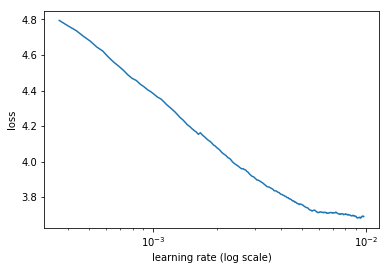

In [39]:
learner.sched.plot()

In [40]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

HBox(children=(IntProgress(value=0, description='Epoch', max=15), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.720808   3.323554   0.430396  
    1      3.462717   3.194241   0.444766                   
    2      3.296841   3.145685   0.44934                    
    3      3.189659   3.116823   0.452678                   
    4      3.076993   3.110479   0.454128                   
    5      3.003034   3.103891   0.455656                   
    6      2.966972   3.096788   0.456048                   
    7      2.857051   3.112234   0.456032                   
    8      2.845529   3.106192   0.456123                   
    9      2.760158   3.121993   0.455679                   
    10     2.768053   3.117752   0.455845                   
    11     2.682982   3.133739   0.455965                   
    12     2.67588    3.134622   0.455802                   
    13     2.648194   3.140831   0.456006                   
    14     2.624377   3.144132   0.456194                   



[array([ 3.14413]), 0.45619449539882378]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.


In [41]:
math.exp(3.14413)

23.199483140560965

In [42]:
learner.save('lm1')

In [43]:
learner.save_encoder('lm1_enc')

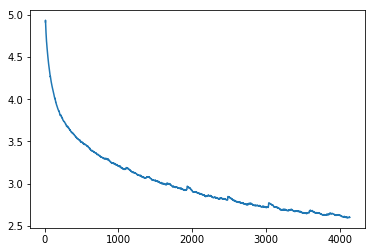

In [44]:
learner.sched.plot_loss()

# Classifier tokens

The classifier model is basically a linear layer custom head on top of the LM backbone. Setting up the classifier data is similar to the LM data setup except that we cannot use the unsup movie reviews this time.



In [46]:
df_trn = pd.read_csv(CLAS_PATH/'train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'val.csv', header=None, chunksize=chunksize)

In [51]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
<class 'pandas.core.frame.DataFrame'>
1
<class 'pandas.core.frame.DataFrame'>
0
<class 'pandas.core.frame.DataFrame'>


In [52]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [7]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [8]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

13289

In [9]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

In [10]:
np.save(CLAS_PATH/'tmp'/'trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'val_ids.npy', val_clas)

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained IMDB backbone. The steps to create the classifier model are similar to the ones for the LM.



In [7]:
trn_clas = np.load(CLAS_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'val_ids.npy')

In [8]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [9]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

NameError: name 'itos' is not defined

In [10]:

min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In the classifier, unlike LM, we need to read a movie review at a time and learn to predict the it's sentiment as pos/neg. We do not deal with equal bptt size batches, so we have to pad the sequences to the same length in each batch. To create batches of similar sized movie reviews, we use a sortish sampler method invented by @Smerity and @jekbradbury

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.



In [11]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

NameError: name 'bs' is not defined

In [16]:
# part 1
dps = np.array([0.4, 0.5, 0.05, 0.3, 0.1])

In [17]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [20]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [21]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [5]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

NameError: name 'md' is not defined

In [23]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [24]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [25]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [26]:
learn.freeze_to(-1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 83%|████████▎ | 1629/1960 [00:34<00:06, 47.44it/s, loss=23.5]

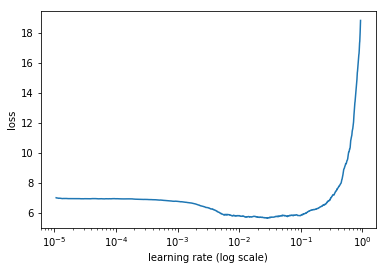

 83%|████████▎ | 1629/1960 [00:50<00:10, 32.55it/s, loss=23.5]

In [27]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [28]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  6%|▌         | 111/1960 [00:02<00:39, 46.79it/s, loss=6.65]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                     
    0      4.719475   4.417757   0.148379  



[array([ 4.41776]), 0.14837896638822781]

In [29]:
learn.save('clas_0')

In [30]:
learn.load('clas_0')

In [31]:
learn.freeze_to(-2)

In [32]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      4.370757   4.19201    0.178369  



[array([ 4.19201]), 0.17836910117409721]

In [35]:
learn.save('clas_1')

In [36]:
learn.load('clas_1')

In [37]:
learn.unfreeze()

In [38]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                     
    0      4.334062   4.266821   0.171857  
    1      4.221147   4.112112   0.183628                     
    2      3.924026   3.974978   0.201829                     
    3      3.842684   3.926219   0.209512                     
    4      3.615162   3.921244   0.216806                     
    5      3.408062   3.91611    0.223713                     
    6      3.279865   3.938781   0.225883                     
    7      3.158943   3.927856   0.224613                     
    8      2.967882   3.946789   0.23106                      
    9      2.901795   3.94001    0.225289                     
    10     2.848268   3.977719   0.232746                     
    11     2.594002   3.939127   0.233168                     
    12     2.558539   3.936608   0.235885                     
    13     2.364262   3.938798   0.240462                     



[array([ 3.9388]), 0.24046209717898492]

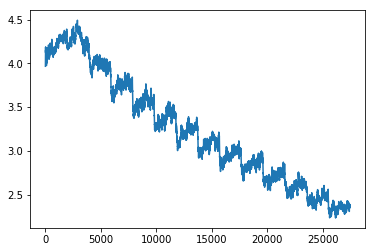

In [39]:
learn.sched.plot_loss()

In [40]:
learn.save('clas_2_973')

We've managed to acheive an acuracy of 25% accuracy with 973 different classes. We can run it again with only 100 classes

# rerun with less classes

need to run top 4 cells if you are recovering from a saved model

In [47]:
categories = []
for i, r in raw_df.iterrows():
    categories.append(r[3])

In [48]:
freq = Counter(categories)
cats = dict(freq)
cats

{'HISTORY': 349,
 "ESPN's TOP 10 ALL-TIME ATHLETES": 5,
 'EVERYBODY TALKS ABOUT IT...': 4,
 'THE COMPANY LINE': 5,
 'EPITAPHS & TRIBUTES': 5,
 '3-LETTER WORDS': 240,
 'DR. SEUSS AT THE MULTIPLEX': 4,
 'PRESIDENTIAL STATES OF BIRTH': 2,
 'AIRLINE TRAVEL': 15,
 'THAT OLD-TIME RELIGION': 15,
 'MUSICAL TRAINS': 5,
 '"X"s & "O"s': 5,
 'THE SOLAR SYSTEM': 46,
 'GEOGRAPHY "E"': 5,
 'RADIO DISNEY': 5,
 'PARTS OF PEACH': 5,
 'BE FRUITFUL & MULTIPLY': 5,
 "LET'S BOUNCE": 5,
 'RHYMES WITH SMART': 5,
 'SCIENCE CLASS': 78,
 'KIDS IN SPORTS': 5,
 'JUST THE FACTS': 5,
 'SEE & SAY': 5,
 'NEWS TO ME': 5,
 'IN THE DICTIONARY': 164,
 'HISTORIC WOMEN': 42,
 'ROYAL FEMALE NICKNAMES': 8,
 'TV ACTORS & ROLES': 40,
 'TRAVEL & TOURISM': 174,
 '"I" LADS': 10,
 'FOREWORDS': 14,
 'BACKWORDS': 47,
 'PEOPLE IN HISTORY': 131,
 'CINEMATIC DICTIONARY': 5,
 "IT'S OURS!": 5,
 'BRITISH FASHION': 8,
 'ANDY WARHOL': 5,
 'THEATRE CROSSWORD CLUES "M"': 15,
 'SPORTS LEGENDS': 43,
 'GENERAL SCIENCE': 144,
 'GETTING POSSESSIVE'

In [52]:
sorted_category_count = sorted(cats.items(), key=lambda kv: -kv[1])
sorted_category_count

[('BEFORE & AFTER', 547),
 ('SCIENCE', 519),
 ('LITERATURE', 496),
 ('AMERICAN HISTORY', 418),
 ('POTPOURRI', 401),
 ('WORLD HISTORY', 377),
 ('WORD ORIGINS', 371),
 ('COLLEGES & UNIVERSITIES', 351),
 ('HISTORY', 349),
 ('SPORTS', 342),
 ('U.S. CITIES', 339),
 ('WORLD GEOGRAPHY', 338),
 ('BODIES OF WATER', 327),
 ('ANIMALS', 324),
 ('STATE CAPITALS', 314),
 ('BUSINESS & INDUSTRY', 311),
 ('ISLANDS', 301),
 ('WORLD CAPITALS', 300),
 ('U.S. GEOGRAPHY', 299),
 ('RELIGION', 297),
 ('SHAKESPEARE', 294),
 ('OPERA', 294),
 ('LANGUAGES', 284),
 ('BALLET', 282),
 ('TELEVISION', 281),
 ('FICTIONAL CHARACTERS', 280),
 ('TRANSPORTATION', 279),
 ('PEOPLE', 279),
 ('RHYME TIME', 279),
 ('ART & ARTISTS', 270),
 ('STUPID ANSWERS', 270),
 ('THE BIBLE', 267),
 ('ART', 258),
 ('BOOKS & AUTHORS', 255),
 ('U.S. HISTORY', 250),
 ('FOOD', 246),
 ('MUSEUMS', 245),
 ('SCIENCE & NATURE', 244),
 ('AMERICANA', 244),
 ('COMMON BONDS', 243),
 ('HOLIDAYS & OBSERVANCES', 242),
 ('GEOGRAPHY', 242),
 ('3-LETTER WORDS',

In [59]:
top100cats =dict(sorted_category_count[:100])
top100cats

{'19th CENTURY AMERICA': 151,
 '3-LETTER WORDS': 240,
 '4-LETTER WORDS': 197,
 '5-LETTER WORDS': 151,
 'ABBREV.': 145,
 'AMERICAN HISTORY': 418,
 'AMERICAN LITERATURE': 234,
 'AMERICANA': 244,
 'ANIMALS': 324,
 'ANNUAL EVENTS': 236,
 'ARCHITECTURE': 180,
 'AROUND THE WORLD': 207,
 'ART': 258,
 'ART & ARTISTS': 270,
 'ASTRONOMY': 199,
 'AUTHORS': 232,
 'AWARDS': 158,
 'BALLET': 282,
 'BEFORE & AFTER': 547,
 'BIOLOGY': 194,
 'BODIES OF WATER': 327,
 'BOOKS & AUTHORS': 255,
 'BUSINESS & INDUSTRY': 311,
 'CHEMISTRY': 151,
 'CLASSICAL MUSIC': 233,
 'COLLEGES & UNIVERSITIES': 351,
 'COMMON BONDS': 243,
 'COMPOSERS': 203,
 'EUROPEAN HISTORY': 184,
 'EXPLORERS': 182,
 'FAMOUS AMERICANS': 159,
 'FASHION': 154,
 'FICTIONAL CHARACTERS': 280,
 'FIRST LADIES': 175,
 'FOOD': 246,
 'FOOD & DRINK': 198,
 'FOREIGN WORDS & PHRASES': 156,
 'FRUITS & VEGETABLES': 170,
 'GENERAL SCIENCE': 144,
 'GEOGRAPHY': 242,
 'GOVERNMENT & POLITICS': 146,
 'HISTORIC NAMES': 194,
 'HISTORY': 349,
 'HODGEPODGE': 222,
 'H

In [66]:
text = []
labels = []
count = 0
for i, r in raw_df.iterrows():
    if r[3] in top100cats:
        text.append(r[5])
        labels.append(r[3])
        count += 1

col_names = ['labels','text']
s_df = pd.DataFrame({'text':text, 'labels':labels}, columns=col_names)
len(s_df)

23892

Now we should have a set of record that are for the top 100 categories. we're going to save this to csv 
so we don't have to do this again

In [67]:
s_df.to_csv('data/cleaned/top100.csv', header=False, index=False)

In [68]:
s_df = pd.read_csv('data/cleaned/top100.csv')

In [69]:
s_df.head(10)

,HISTORY,"For the last 8 years of his life, Galileo was under house arrest for espousing this man's theory"
0,3-LETTER WORDS,"In the title of an Aesop fable, this insect sh..."
1,HISTORY,Built in 312 B.C. to link Rome & the South of ...
2,3-LETTER WORDS,Cows regurgitate this from the first stomach t...
3,HISTORY,In 1000 Rajaraja I of the Cholas battled to ta...
4,3-LETTER WORDS,"A small demon, or a mischievous child (who mig..."
5,HISTORY,Karl led the first of these Marxist organizati...
6,3-LETTER WORDS,"In geologic time one of these, shorter than an..."
7,HISTORY,This Asian political party was founded in 1885...
8,3-LETTER WORDS,"A single layer of paper, or to perform one's c..."
9,IN THE DICTIONARY,It's the 4-letter name of the pleated skirt wo...


In [79]:
all_txt, all_label = get_text_and_labels(s_df)

In [81]:
np.random.seed(42)
rnd_idx = np.random.permutation(len(all_txt));
print(len(rnd_idx))

all_txt = all_txt[rnd_idx]
all_label = all_label[rnd_idx]

23891


In [82]:
split = round(len(all_txt)*0.75)
trn_texts = all_txt[0: split]
trn_labels = all_label[0: split]

val_texts = all_txt[split:]
val_labels = all_label[split:]

len(trn_texts),len(val_texts)

(17918, 5973)

In [83]:
col_names = ['labels','text']
trn_df = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
print(trn_df.head(10))
trn_df.to_csv('data/clasificaiton/100train.csv', header=False, index=False)


val_df = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)
val_df.to_csv('data/clasificaiton/100val.csv', header=False, index=False)

   labels                                               text
0       5  This grandson of the ninth president commanded...
1      99  The name of this ceremonial form of Japanese s...
2      84  This desert in southern Africa has long been h...
3       6  It's the solid part of the earth as distinguis...
4      69  Arginine, one of these acids, is made in the b...
5      23  It can be a colorful vegetable dish, an herb l...
6      23  Ash Wednesday is a movable feast falling this ...
7      71  Commercial growers usually brush most of the f...
8      30  Sherwood Anderson helped this Mississippi auth...
9      45  The cheery first "Masterpiece Theatre" season ...


In [85]:
chunksize=24000

In [106]:
df_trn = pd.read_csv(CLAS_PATH/'100train.csv', header=None, chunksize=chunksize)
df_val = pd.read_csv(CLAS_PATH/'100val.csv', header=None, chunksize=chunksize)

In [109]:
tok_trn, trn_labels = get_all(df_trn, 1)
tok_val, val_labels = get_all(df_val, 1)

0
<class 'pandas.core.frame.DataFrame'>
0
<class 'pandas.core.frame.DataFrame'>


In [110]:
tok_trn

[['\n',
  'xbos',
  'xfld',
  '1',
  'this',
  'grandson',
  'of',
  'the',
  'ninth',
  'president',
  'commanded',
  'troops',
  'in',
  'the',
  'army',
  'of',
  'the',
  'cumberland'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  'the',
  'name',
  'of',
  'this',
  'ceremonial',
  'form',
  'of',
  'japanese',
  'suicide',
  'means',
  'to',
  '"',
  'cut',
  'your',
  'belly',
  '"'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  'this',
  'desert',
  'in',
  'southern',
  'africa',
  'has',
  'long',
  'been',
  'home',
  'to',
  'the',
  'san',
  ',',
  'or',
  'bushmen'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  'it',
  "'s",
  'the',
  'solid',
  'part',
  'of',
  'the',
  'earth',
  'as',
  'distinguished',
  'from',
  'the',
  'atmosphere',
  '&',
  'hydrosphere'],
 ['\n',
  'xbos',
  'xfld',
  '1',
  'arginine',
  ',',
  'one',
  'of',
  'these',
  'acids',
  ',',
  'is',
  'made',
  'in',
  'the',
  'body',
  'but',
  'not',
  'enough',
  'for',
  'growth',
  '--',
  'so',
  'it',
  "'s",
  

In [111]:
(CLAS_PATH/'tmp').mkdir(exist_ok=True)

np.save(CLAS_PATH/'tmp'/'tok_trn.npy', tok_trn)
np.save(CLAS_PATH/'tmp'/'tok_val.npy', tok_val)

np.save(CLAS_PATH/'tmp'/'trn_labels.npy', trn_labels)
np.save(CLAS_PATH/'tmp'/'val_labels.npy', val_labels)

In [112]:
tok_trn = np.load(CLAS_PATH/'tmp'/'tok_trn.npy')
tok_val = np.load(CLAS_PATH/'tmp'/'tok_val.npy')

In [12]:
itos = pickle.load((LM_PATH/'tmp'/'itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

13289

In [13]:
trn_clas = np.array([[stoi[o] for o in p] for p in tok_trn])
val_clas = np.array([[stoi[o] for o in p] for p in tok_val])

NameError: name 'tok_trn' is not defined

In [115]:
np.save(CLAS_PATH/'tmp'/'100trn_ids.npy', trn_clas)
np.save(CLAS_PATH/'tmp'/'100val_ids.npy', val_clas)

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained IMDB backbone. The steps to create the classifier model are similar to the ones for the LM

In [14]:
trn_clas = np.load(CLAS_PATH/'tmp'/'100trn_ids.npy')
val_clas = np.load(CLAS_PATH/'tmp'/'100val_ids.npy')

In [15]:
trn_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'trn_labels.npy'))
val_labels = np.squeeze(np.load(CLAS_PATH/'tmp'/'val_labels.npy'))

In [16]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [17]:
trn_labels

array([ 5, 99, 84, ..., 27, 36, 65])

In [18]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

In [19]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [20]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])

In [21]:
m = get_rnn_classifer(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [22]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [23]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=.25
learn.metrics = [accuracy]

In [154]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [155]:
lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [156]:
wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [157]:
learn.freeze_to(-1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 28%|██▊       | 210/747 [00:04<00:11, 45.11it/s, loss=3.05]

Exception in thread Thread-73:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 83%|████████▎ | 623/747 [00:13<00:02, 44.66it/s, loss=11.9]


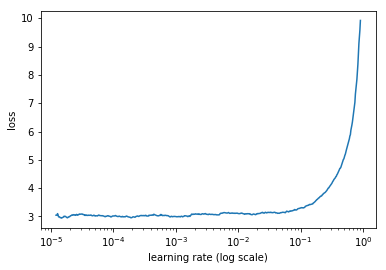

In [158]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [159]:
learn.fit(lrs, 1, wds=wd, cycle_len=2, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.907975   2.334593   0.369323  
    1      2.888575   2.280884   0.379462                   



[array([ 2.28088]), 0.37946159505499205]

In [160]:
learn.freeze_to(-2)

In [161]:
learn.fit(lrs, 1, wds=wd, cycle_len=4, use_clr=(8,3))

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.849323   2.278189   0.371327  
    1      2.705004   2.211544   0.397324                   
    2      2.63363    2.152868   0.411932                   
    3      2.573765   2.130533   0.415952                   



[array([ 2.13053]), 0.41595194796757068]

In [162]:
learn.unfreeze()

In [163]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      2.530731   2.128845   0.413162  
    1      2.491852   2.097793   0.424012                   
    2      2.26269    2.116339   0.425071                   
    3      2.293563   2.070211   0.430856                   
    4      2.192553   2.063016   0.44404                    
    5      2.167653   2.03224    0.442582                   
    6      2.040352   2.040977   0.447951                   
    7      2.046911   2.005274   0.455011                   
    8      1.957838   2.018932   0.449126                   
    9      1.943775   1.994754   0.462611                   
    10     1.945358   2.003034   0.456875                   
    11     1.842716   1.994821   0.461935                   
    12     1.777045   1.994117   0.461466                   
    13     1.811407   1.998937   0.460458                   



[array([ 1.99894]), 0.46045810677259352]

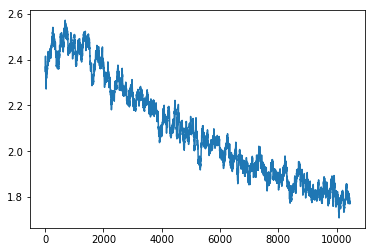

In [164]:
learn.sched.plot_loss()

In [168]:
learn.save('clas_2_100')

In [24]:
learn.load('clas_2_100')

# upload to s3

In [165]:
import os

In [166]:
def get_relative_path(filename):
    s1 = os.path.split(filename)
    p = os.path.split(s1[0])[1]
    return os.path.join(p, s1[1])


In [167]:
def create_dummy_data(src_path, dest_root, sub_dir, num_items=2):
    if not os.path.isdir(dest_root): os.mkdir(dest_root)
    dst_path = os.path.join(dest_root, sub_dir)
    classes = os.listdir(src_path)
    for d in classes:
        if d.startswith('.'): continue
        if not os.path.isdir(dst_path): os.mkdir(dst_path)
        if not os.path.isdir(os.path.join(dst_path, d)): os.mkdir(os.path.join(dst_path, d))
        fnames = glob('{}/{}/*.jpg'.format(src_path, d))
        for i in range(num_items):
            shutil.copyfile(fnames[i], os.path.join(dst_path, get_relative_path(fnames[i])))


In [169]:
!tar czvf data/model.tar.gz --exclude='tmp.h5' -C data/models/ .

./
./clas_0.h5
./clas_2.h5
./lm1.h5
./clas_1.h5
./lm1_enc.h5
./wt103/
./wt103/bwd_wt103_enc.h5
./wt103/fwd_wt103_enc.h5
./wt103/index.html?C=M;O=D
./wt103/fwd_wt103.h5
./wt103/itos_wt103.pkl
./wt103/index.html
./wt103/bwd_wt103.h5
./wt103/index.html?C=N;O=A
./wt103/index.html?C=M;O=A
./wt103/index.html?C=S;O=A
./wt103/index.html?C=S;O=D
./wt103/index.html?C=D;O=A
./wt103/index.html?C=N;O=D
./wt103/index.html?C=D;O=D
./clas_2_100.h5
./lm_last_ft.h5


In [174]:
bucket = 'deep-learning-sagemaker'
key = "models/class100/model.tar.gz"
boto3.client('s3').upload_file('data/model.tar.gz', bucket, key)
print(f"Uploaded model artefacts to s3://{bucket}/{key}")

Uploaded model artefacts to s3://deep-learning-sagemaker/models/class100/model.tar.gz
